In [7]:
!pip install imbalanced-learn

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc

df=pd.read_csv("credit_card_fraud_dataset.csv")
df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [15]:
print(df.columns)

Index(['TransactionID', 'TransactionDate', 'Amount', 'IsFraud',
       'TransactionType_refund', 'Location_Dallas', 'Location_Houston',
       'Location_Los Angeles', 'Location_New York', 'Location_Philadelphia',
       ...
       'MerchantID_991', 'MerchantID_992', 'MerchantID_993', 'MerchantID_994',
       'MerchantID_995', 'MerchantID_996', 'MerchantID_997', 'MerchantID_998',
       'MerchantID_999', 'MerchantID_1000'],
      dtype='object', length=1013)


In [29]:
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)


Dataset Shape: (100000, 1013)
Columns: Index(['TransactionID', 'TransactionDate', 'Amount', 'IsFraud',
       'TransactionType_refund', 'Location_Dallas', 'Location_Houston',
       'Location_Los Angeles', 'Location_New York', 'Location_Philadelphia',
       ...
       'MerchantID_991', 'MerchantID_992', 'MerchantID_993', 'MerchantID_994',
       'MerchantID_995', 'MerchantID_996', 'MerchantID_997', 'MerchantID_998',
       'MerchantID_999', 'MerchantID_1000'],
      dtype='object', length=1013)


In [36]:
df.drop(columns=['TransactionID', 'TransactionDate'], errors='ignore', inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

In [38]:
columns_to_encode = ['TransactionType', 'Location', 'MerchantID']
existing_columns = [col for col in columns_to_encode if col in df.columns]
df = pd.get_dummies(df, columns=existing_columns, drop_first=True)
df

,Amount,IsFraud,TransactionType_refund,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,...,MerchantID_991,MerchantID_992,MerchantID_993,MerchantID_994,MerchantID_995,MerchantID_996,MerchantID_997,MerchantID_998,MerchantID_999,MerchantID_1000
0,4189.27,0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2659.71,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,784.00,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3514.40,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,369.07,0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1057.29,0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99996,297.25,0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99997,3448.56,0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99998,3750.79,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
target = 'IsFraud'
X = df.drop(columns=[target])
y = df[target]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [54]:
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("\nRandom Forest Performance:")
print(f"Accuracy: {rf_accuracy:.4f}, ROC-AUC: {rf_roc_auc:.4f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.9921, ROC-AUC: 0.9997
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19777
           1       0.99      0.99      0.99     19823

    accuracy                           0.99     39600
   macro avg       0.99      0.99      0.99     39600
weighted avg       0.99      0.99      0.99     39600



In [56]:
print("\nXGBoost Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}, ROC-AUC: {xgb_roc_auc:.4f}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Performance:
Accuracy: 0.9694, ROC-AUC: 0.9951
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     19777
           1       1.00      0.94      0.97     19823

    accuracy                           0.97     39600
   macro avg       0.97      0.97      0.97     39600
weighted avg       0.97      0.97      0.97     39600



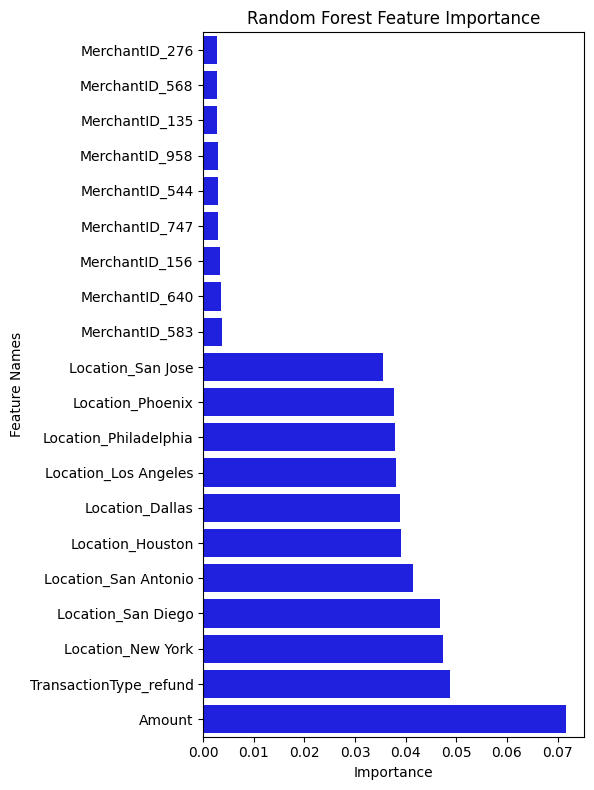

In [78]:
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

feature_names = X.columns
sorted_indices_rf = np.argsort(rf_importances)[-20:] 
sorted_indices_xgb = np.argsort(xgb_importances)[-20:]

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.barplot(x=rf_importances[sorted_indices_rf], y=np.array(feature_names)[sorted_indices_rf], color='blue')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

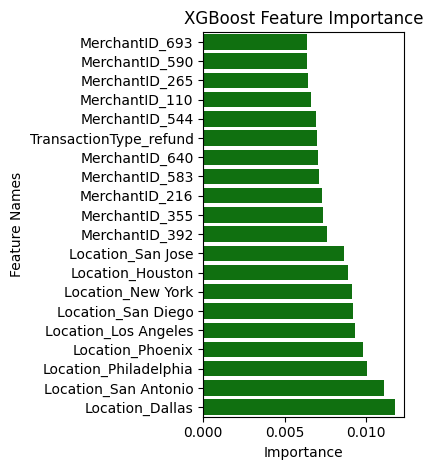

In [80]:
plt.subplot(1, 2, 2)
sns.barplot(x=xgb_importances[sorted_indices_xgb], y=np.array(feature_names)[sorted_indices_xgb], color='green')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()